CNN TUBERKULOSIS (70% TRAIN, 20% VAL, 10% TEST)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "../content/drive/MyDrive/Colab Notebooks/Dataset/chest-xray-tb"

'New Text Document.txt'   test	 train	 val


In [ ]:
!pip install matplotlib-venn

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Dropout, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Changed the import path to use tensorflow.keras.preprocessing.image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [ ]:
def load_images(image_path):
    files = np.array(os.listdir(image_path))

    images = []
    for image in tqdm(files):
        # Read image
        img_path = os.path.join(image_path, image) # Create the full image path using os.path.join to avoid potential path issues
        image = cv2.imread(img_path)

        if image is not None: # Check if the image was loaded correctly
            # Resize image to 224x224 px
            image = cv2.resize(image, (224,224), interpolation=cv2.INTER_AREA)
            images.append(image)
        else:
            print(f"Failed to load image: {img_path}") # Print an error message if the image cannot be loaded

    images = np.array(images)

    return images

In [ ]:
# Fungsi load_images untuk memuat gambar dari direktori
normal_train = load_images('../content/drive/MyDrive/Colab Notebooks/Dataset/chest-xray-tb/train/normal')
aktif_train = load_images('../content/drive/MyDrive/Colab Notebooks/Dataset/chest-xray-tb/train/aktif')
laten_train = load_images('../content/drive/MyDrive/Colab Notebooks/Dataset/chest-xray-tb/train/laten')

normal_val = load_images('../content/drive/MyDrive/Colab Notebooks/Dataset/chest-xray-tb/val/normal')
aktif_val  = load_images('../content/drive/MyDrive/Colab Notebooks/Dataset/chest-xray-tb/val/aktif')
laten_val  = load_images('../content/drive/MyDrive/Colab Notebooks/Dataset/chest-xray-tb/val/laten')

normal_test = load_images('../content/drive/MyDrive/Colab Notebooks/Dataset/chest-xray-tb/test/normal')
aktif_test = load_images('../content/drive/MyDrive/Colab Notebooks/Dataset/chest-xray-tb/test/aktif')
laten_test = load_images('../content/drive/MyDrive/Colab Notebooks/Dataset/chest-xray-tb/test/laten')

100%|██████████| 150/150 [00:19<00:00,  7.63it/s]


In [ ]:
# Label numerik
laten_labels = [2] * len(laten_train)
aktif_labels = [1] * len(aktif_train)
normal_labels = [0] * len(normal_train)

laten_test_labels = [2] * len(laten_test)
aktif_test_labels = [1] * len(aktif_test)
normal_test_labels = [0] * len(normal_test)

laten_val_labels = [2] * len(laten_val)
aktif_val_labels = [1] * len(aktif_val)
normal_val_labels = [0] * len(normal_val)

In [ ]:
# Gabungkan data TRAIN
X_train = np.concatenate((normal_train, aktif_train, laten_train), axis=0)
y_train = np.array(normal_labels + aktif_labels + laten_labels)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Gabungkan data VALIDASI
X_val = np.concatenate((normal_val, aktif_val, laten_val), axis=0)
y_val = np.array(normal_val_labels + aktif_val_labels + laten_val_labels)
X_val, y_val = shuffle(X_val, y_val, random_state=42)

# Gabungkan data TEST
X_test = np.concatenate((normal_test, aktif_test, laten_test), axis=0)
y_test = np.array(normal_test_labels + aktif_test_labels + laten_test_labels)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [ ]:
# Normalisasi citra ke 0–1
X_train = X_train / 255.0
X_val   = X_val / 255.0
X_test  = X_test / 255.0

In [ ]:
# One-hot encoding label
y_train = to_categorical(y_train, num_classes=3)
y_val   = to_categorical(y_val, num_classes=3)
y_test  = to_categorical(y_test, num_classes=3)

In [ ]:
# Input layer, ukuran citra 224x224 dengan 3 channel warna (RGB)
input_layer = Input(shape=(224, 224, 3))

# Convolutional layer pertama dengan 16 filter, ukuran kernel 3x3, padding 'same', dan aktivasi ReLU
cnn = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)

# Max pooling layer dengan ukuran pool 2x2
cnn = MaxPool2D((2, 2))(cnn)

# Convolutional layer kedua dengan 32 filter, ukuran kernel 3x3, padding 'same', dan aktivasi ReLU
cnn = Conv2D(32, (3, 3), activation='relu', padding='same')(cnn)

# Max pooling layer kedua dengan ukuran pool 2x2
cnn = MaxPool2D((2, 2))(cnn)

# Convolutional layer ketiga dengan 64 filter, ukuran kernel 3x3, padding 'same', dan aktivasi ReLU
cnn = Conv2D(64, (3, 3), activation='relu', padding='same')(cnn)

# Max pooling layer ketiga dengan ukuran pool 2x2
cnn = MaxPool2D((2, 2))(cnn)

# Flatten layer untuk meratakan output dari layer sebelumnya menjadi vektor satu dimensi
cnn = Flatten()(cnn)

# Dropout layer dengan rate 0.5 untuk mencegah overfitting
cnn = Dropout(0.5)(cnn)

# Fully connected (Dense) layer dengan 128 neuron dan aktivasi ReLU
cnn = Dense(128, activation='relu')(cnn)

# Dropout layer kedua dengan rate 0.5 untuk mencegah overfitting
cnn = Dropout(0.5)(cnn)

# Output layer dengan 3 neuron (untuk 3 kelas) dan aktivasi Softmax untuk klasifikasi multi-kelas
output_layer = Dense(3, activation='softmax')(cnn)

# Membuat model dengan input dan output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
# Mengompilasi model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Fit data augmentation pada data training
datagen.fit(X_train)

In [ ]:
# Callback untuk menyimpan model terbaik
checkpoint = ModelCheckpoint(
    'model_multiclass.keras',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

# Training model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=150,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint],
    shuffle=True
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.4456 - loss: 1.1745
Epoch 1: val_accuracy improved from -inf to 0.45444, saving model to model_multiclass.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 56s 486ms/step - accuracy: 0.4462 - loss: 1.1726 - val_accuracy: 0.4544 - val_loss: 1.1200
Epoch 2/150
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.5980 - loss: 0.8559
Epoch 2: val_accuracy improved from 0.45444 to 0.52222, saving model to model_multiclass.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 45s 453ms/step - accuracy: 0.5981 - loss: 0.8557 - val_accuracy: 0.5222 - val_loss: 0.9509
Epoch 3/150
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.6566 - loss: 0.7702
Epoch 3: val_accuracy improved from 0.52222 to 0.66222, saving model to model_multiclass.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 387ms/step - accuracy: 0.6566 - loss: 0.7702 - val_accuracy: 0.6622 - val_loss: 0.8190
Epoch 4/150
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.6720 - loss: 0.7413
Epoch 4: val_acc

In [ ]:
# Simpan model ke dalam drive
model.save('../content/drive/MyDrive/Colab Notebooks/Dataset/CNN-(70 20 10).keras')

In [ ]:
# Evaluasi model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 1.2569
Test Accuracy: 0.7289


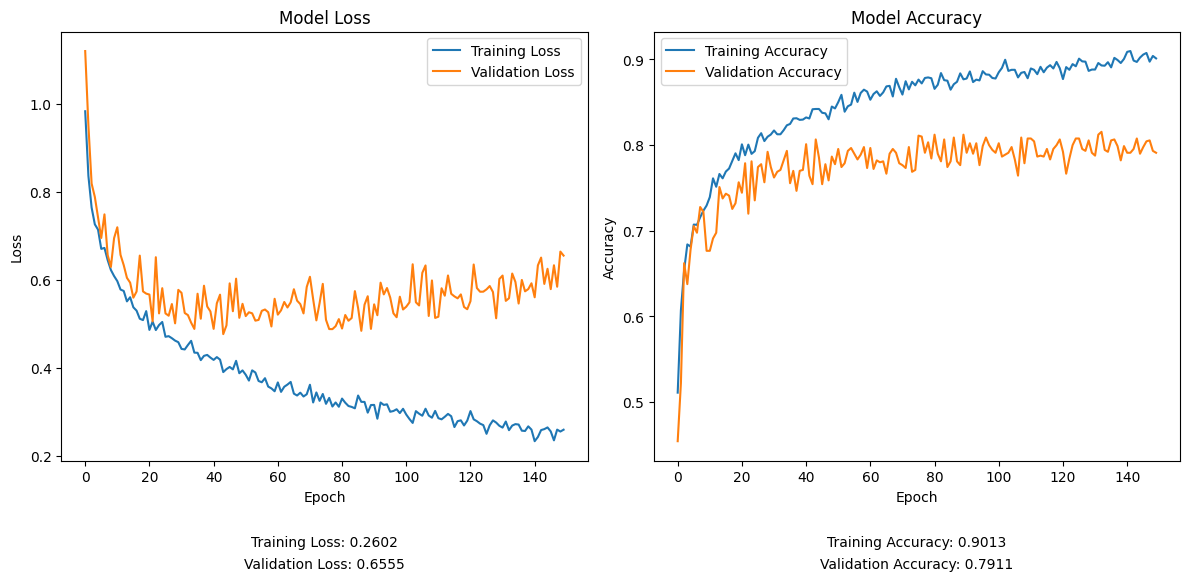

In [ ]:
# Membuat subplots dengan 1 baris dan 2 kolom
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Visualisasi Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

# Menampilkan nilai terakhir loss di bawah grafik
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
axes[0].text(0.5, -0.2, f'Training Loss: {final_train_loss:.4f}', fontsize=10, ha='center', transform=axes[0].transAxes)
axes[0].text(0.5, -0.25, f'Validation Loss: {final_val_loss:.4f}', fontsize=10, ha='center', transform=axes[0].transAxes)

# Visualisasi Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

# Menampilkan nilai terakhir accuracy di bawah grafik
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
axes[1].text(0.5, -0.2, f'Training Accuracy: {final_train_accuracy:.4f}', fontsize=10, ha='center', transform=axes[1].transAxes)
axes[1].text(0.5, -0.25, f'Validation Accuracy: {final_val_accuracy:.4f}', fontsize=10, ha='center', transform=axes[1].transAxes)

# Menambahkan legend ke kedua grafik
axes[0].legend()
axes[1].legend()

# Menampilkan plot
plt.tight_layout()  # Untuk mengatur jarak antar grafik
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


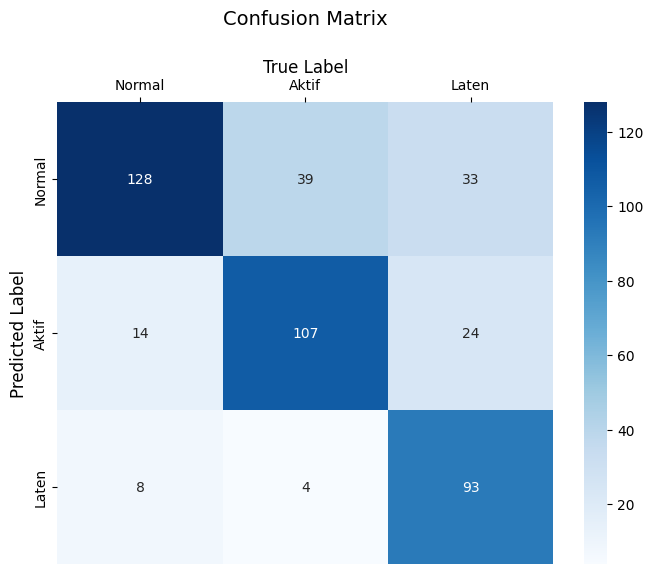

Accuracy:  0.7289
Precision: 0.7545
Recall:    0.7289
F1 Score:  0.7288

Classification Report:
              precision    recall  f1-score   support

      Normal       0.64      0.85      0.73       150
       Aktif       0.74      0.71      0.73       150
       Laten       0.89      0.62      0.73       150

    accuracy                           0.73       450
   macro avg       0.75      0.73      0.73       450
weighted avg       0.75      0.73      0.73       450



In [ ]:
# Mengambil label asli dari one-hot encoding
y_true = np.argmax(y_test, axis=1)

# Mendapatkan prediksi dari model pada data test
y_pred = model.predict(X_test)

# Mengambil kelas dengan probabilitas tertinggi sebagai prediksi kelas
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix (baris = prediksi, kolom = label asli)
cm = confusion_matrix(y_pred_classes, y_true)
class_names = ['Normal', 'Aktif', 'Laten']  # Sesuaikan jika perlu

plt.figure(figsize=(8,6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=class_names, yticklabels=class_names)

# Pindahkan label x ke atas
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xlabel('True Label', fontsize=12)
plt.ylabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix\n', pad=40, fontsize=14)  # Beri jarak agar tidak numpuk

plt.show()

# Import necessary metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Evaluasi metrik
print(f"Accuracy:  {accuracy_score(y_true, y_pred_classes):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"F1 Score:  {f1_score(y_true, y_pred_classes, average='macro'):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)  # Mengambil kelas dengan probabilitas tertinggi

# Nama kelas untuk multi-kelas
class_names = ['Normal', 'Laten', 'Aktif']

# Evaluasi metrik
print(f"Accuracy:  {accuracy_score(y_true, y_pred_classes):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"F1 Score:  {f1_score(y_true, y_pred_classes, average='macro'):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Accuracy:  0.7289
Precision: 0.7545
Recall:    0.7289
F1 Score:  0.7288

Classification Report:
              precision    recall  f1-score   support

      Normal       0.64      0.85      0.73       150
       Laten       0.74      0.71      0.73       150
       Aktif       0.89      0.62      0.73       150

    accuracy                           0.73       450
   macro avg       0.75      0.73      0.73       450
weighted avg       0.75      0.73      0.73       450



In [ ]:
# Menampilkan classification report
print("\nClassification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred_classes, target_names=['Normal', 'Laten', 'Aktif']))



Classification Report:
              precision    recall  f1-score   support

      Normal       0.64      0.85      0.73       150
       Laten       0.74      0.71      0.73       150
       Aktif       0.89      0.62      0.73       150

    accuracy                           0.73       450
   macro avg       0.75      0.73      0.73       450
weighted avg       0.75      0.73      0.73       450



In [ ]:
import pandas as pd

# Membuat DataFrame untuk hasil prediksi
pred_df = pd.DataFrame({
    'True Label': np.argmax(y_test, axis=1),
    'Predicted Label': y_pred_classes
})

# Menyimpan hasil prediksi ke dalam file CSV
pred_df.to_csv('../content/drive/MyDrive/Colab Notebooks/Dataset/predictions.csv', index=False)


# LOAD MODEL

In [ ]:
model = load_model('../content/drive/MyDrive/Colab Notebooks/Dataset/CNN-(70 20 10).keras')

In [ ]:
def load_test_images(folder_path, label):
    images = []
    labels = []
    filenames = []

    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        image = cv2.imread(img_path)
        if image is not None:
            image = cv2.resize(image, (224, 224))
            images.append(image)
            labels.append(label)
            filenames.append(file)

    return images, labels, filenames

normal_test, normal_test_labels, normal_names = load_test_images("../content/drive/MyDrive/Colab Notebooks/Dataset/chest-xray-tb/test/normal", 0)
aktif_test, aktif_test_labels, aktif_names = load_test_images("../content/drive/MyDrive/Colab Notebooks/Dataset/chest-xray-tb/test/aktif", 1)
laten_test, laten_test_labels, laten_names = load_test_images("../content/drive/MyDrive/Colab Notebooks/Dataset/chest-xray-tb/test/laten", 2)

In [ ]:
def show_prediction_grid(images, true_labels, pred_labels, pred_probs, class_names, n=25):
    plt.figure(figsize=(8, 8))
    indices = np.random.choice(len(images), n, replace=False)

    for i, idx in enumerate(indices):
        image = images[idx]
        true_label = true_labels[idx]
        pred_label = pred_labels[idx]
        prob = np.max(pred_probs[idx]) * 100

        plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"T:{class_names[true_label]}\nP:{class_names[pred_label]} ({prob:.1f}%)",
                  color=color, fontsize=9)

    plt.tight_layout()
    plt.show()

In [ ]:
X_test = np.concatenate((normal_test, aktif_test, laten_test), axis=0)
y_test = np.array(normal_test_labels + aktif_test_labels + laten_test_labels)
filenames = normal_names + aktif_names + laten_names


In [ ]:
X_test_original = X_test.copy()
X_test = X_test / 255.0

predicted_probs = model.predict(X_test)
predicted_classes = np.argmax(predicted_probs, axis=1)
confidences = np.max(predicted_probs, axis=1)


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step


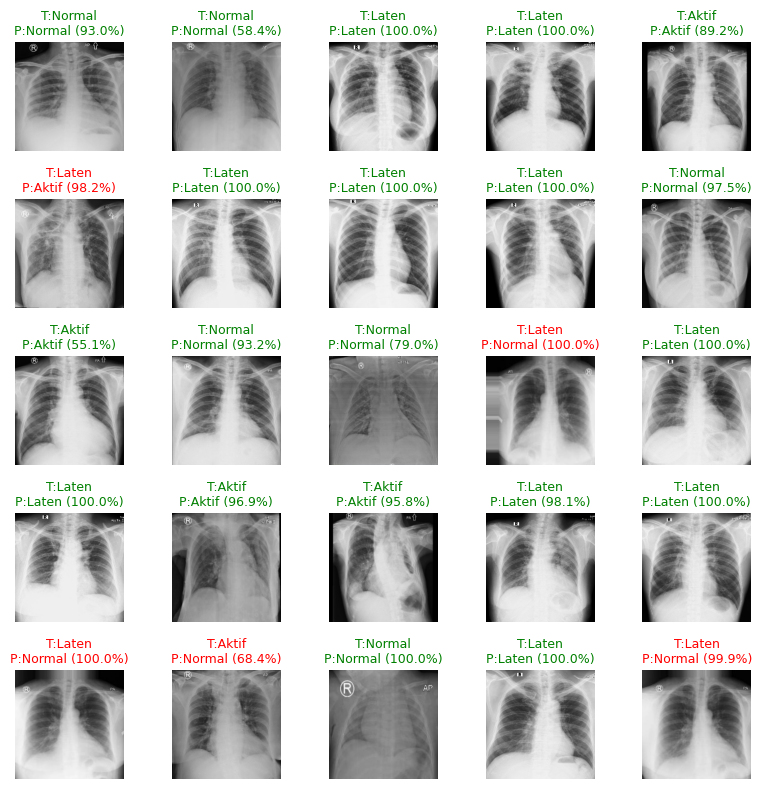

In [ ]:
show_prediction_grid(
    images=X_test_original,  # versi asli citra (tanpa normalisasi)
    true_labels=y_test,
    pred_labels=predicted_classes,
    pred_probs=predicted_probs,
    class_names=['Normal', 'Aktif', 'Laten'],
    n=25  # jumlah gambar ditampilkan
)

In [ ]:
import pandas as pd

# Daftar nama kelas
class_names = ['Normal', 'Aktif', 'Laten']

# Buat DataFrame hasil prediksi
df_results = pd.DataFrame({
    "Filename": filenames,
    "True Label": [class_names[i] for i in y_test],
    "Predicted Label": [class_names[i] for i in predicted_classes],
    "Confidence": confidences * 100,
    "Status": ["Benar" if y_true == y_pred else "Salah"
               for y_true, y_pred in zip(y_test, predicted_classes)]
})

# Path direktori penyimpanan di Google Drive
save_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/Hasil"

# Simpan ke CSV dan Excel
df_results.to_csv(save_path + "hasil_prediksi.csv", index=False)
df_results.to_excel(save_path + "hasil_prediksi.xlsx", index=False)

print("✅ Hasil prediksi berhasil disimpan ke Google Drive sebagai CSV dan Excel.")


✅ Hasil prediksi berhasil disimpan ke Google Drive sebagai CSV dan Excel.
